In [10]:
import os
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import rasterio.mask as rio_mask
import rasterio.warp as rio_warp
from rasterio.enums import Resampling
from rasterio.io import MemoryFile

In [2]:
data_path = Path(os.environ["DATA_PATH"])
results_path = Path("./results")

In [3]:
limit = gpd.read_file(results_path / "platform" / "limite_urbano.geojson")

In [23]:
scale_factor = 2

with rio.open(
    data_path / "datos" / "Basin_01_reclass" / "Basin_01_Reclass_ok.tif",
) as ds_initial:
    limit = limit.to_crs(ds_initial.crs)

    data = ds_initial.read(
        out_shape=(
            ds_initial.count,
            ds_initial.height // scale_factor,
            ds_initial.width // scale_factor,
        ),
        resampling=Resampling.nearest,
    )

    with MemoryFile() as memfile:
        with memfile.open(
            driver="GTiff",
            height=data.shape[1],
            width=data.shape[2],
            count=ds_initial.count,
            dtype=data.dtype,
            crs=ds_initial.crs,
            transform=ds_initial.transform
            * ds_initial.transform.scale(
                (ds_initial.width / data.shape[2]),
                (ds_initial.height / data.shape[1]),
            ),
        ) as ds_intermediate:
            ds_intermediate.write(data)

        with memfile.open() as ds_intermediate:
            masked, transform = rio_mask.mask(
                ds_intermediate,
                [limit["geometry"].item()],
                crop=True,
            )
            masked = masked.squeeze()
            masked[masked == ds_initial.nodata] = 0
            profile = ds_intermediate.profile

            final_transform, final_width, final_height = (
                rio_warp.calculate_default_transform(
                    ds_intermediate.crs,
                    "EPSG:4326",
                    ds_intermediate.width,
                    ds_intermediate.height,
                    *ds_intermediate.bounds,
                )
            )

            final_data, final_transform = rio_warp.reproject(
                masked,
                np.empty((final_height, final_width), dtype=masked.dtype),
                src_transform=transform,
                src_crs=ds_intermediate.crs,
                dst_transform=final_transform,
                dst_width=final_width,
                dst_height=final_height,
                dst_crs="EPSG:4326",
            )

profile["transform"] = final_transform
profile["height"], profile["width"] = final_data.shape
profile["compress"] = "lzw"
profile["nodata"] = 0
profile["crs"] = "EPSG:4326"

with rio.open(
    results_path / "platform" / "inundaciones_raster.tif",
    "w",
    **profile,
) as dst:
    dst.write(final_data, 1)

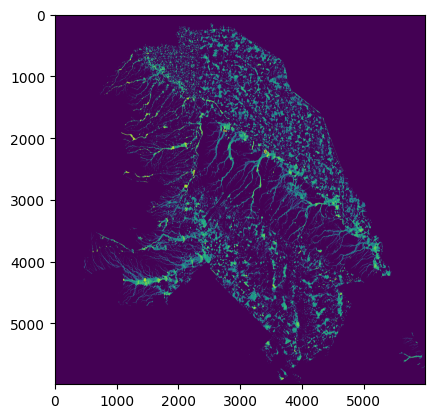

In [21]:
plt.imshow(masked)

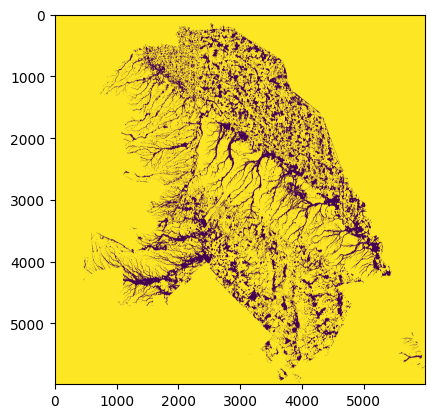

In [22]:
plt.imshow(masked == 0)